# Yolo V3 Eye Detection (Using Open Images V4 Subset)

(Data available from https://www.figure-eight.com/dataset/open-images-annotated-with-bounding-boxes/)

In [2]:
from toolz.curried import *
from funcy import compose, partial, flatten
from os import listdir as ls
from os.path import join, expanduser, abspath
import matplotlib.pyplot as plt
import pandas as pd
import sys

# Add path to keras-yolo implementation
sys.path.append(abspath('./keras-yolo3'))

DIR = expanduser('/media/rcdilorenzo/datahouse/openimagesv4')

data_frame = compose(pd.read_csv, partial(join, DIR))

class_desc = pd.read_csv(join(DIR, 'class-descriptions-boxable.csv'), header=0,
                         names=['LabelName', 'Description'])

# Annotation bounding boxes (train set)
train_ann_bbox      = data_frame('train-annotations-bbox.csv')
# Label w/ confidence by image id (train set)
train_ann_label_box = data_frame('train-annotations-human-imagelabels-boxable.csv')
# Image name with URL (train set)
train_img_box       = data_frame('train-images-boxable.csv')
# Image metadata (e.g. copyright, origin, author, rotation amount) (train set)
train_img_box_rot   = data_frame('train-images-boxable-with-rotation.csv')

# Annotation bounding boxes (validation set)
val_ann_bbox       = data_frame('validation-annotations-bbox.csv')
# Label w/ confidence by image id (validation set)
val_ann_label_box  = data_frame('validation-annotations-human-imagelabels-boxable.csv')
# Image metadata (e.g. copyright, origin, author, rotation amount) (validation set)
val_img_rot        = data_frame('validation-images-with-rotation.csv')

# Annotation bounding boxes (test set)
test_ann_bbox       = data_frame('test-annotations-bbox.csv')
# Label w/ confidence by image id (test set)
test_ann_label_box  = data_frame('test-annotations-human-imagelabels-boxable.csv')
# Image metadata (e.g. copyright, origin, author, rotation amount) (test set)
test_img_rot        = data_frame('test-images-with-rotation.csv')

With these basic imports, the goal is to filter only on the "Human eye" class to build the appropriate model.

In [3]:
LABEL = class_desc[class_desc.Description == 'Human eye'].iloc[0].at['LabelName']
LABEL

'/m/014sv8'

Because this training will be performed on the freely downloadable subset of Open Images V4 (without Google Cloud bucket transfer fees), the annotation metadata needs to not only be filtered on the human eye class but also based on what images are actually included in the subset.

In [4]:
TRAIN_DIRS = ['train_00', 'train_01', 'train_02', 'train_03',
              'train_04', 'train_05', 'train_06', 'train_07',
              'train_08']

sans_ext = lambda f: f[:-4]

open_images_ls = compose(ls, partial(join, DIR))

image_ids_from = compose(list, map(sans_ext), flatten, map(open_images_ls))

train_image_ids = image_ids_from(TRAIN_DIRS)
test_image_ids  = image_ids_from(['test'])
val_image_ids   = image_ids_from(['validation'])

def eye_filter_subset(name, df, ids):
    filtered_df = df[(df.LabelName == LABEL) & (df.ImageID.isin(ids))]
    print(name, filtered_df.shape)
    return filtered_df

In [5]:
train_ann_bbox = eye_filter_subset(
    'train_ann_bbox', train_ann_bbox, train_image_ids)
train_ann_label_box = eye_filter_subset(
    'train_ann_label_box', train_ann_label_box, train_image_ids)

val_ann_bbox = eye_filter_subset(
    'val_ann_bbox', val_ann_bbox, val_image_ids)
val_ann_label_box = eye_filter_subset(
    'val_ann_label_box', val_ann_label_box, val_image_ids)

test_ann_bbox = eye_filter_subset(
    'test_ann_bbox', test_ann_bbox, test_image_ids)
test_ann_label_box = eye_filter_subset(
    'test_ann_label_box', test_ann_label_box, test_image_ids)

train_ann_bbox (77233, 13)
train_ann_label_box (36272, 4)
val_ann_bbox (4304, 13)
val_ann_label_box (5077, 4)
test_ann_bbox (13034, 13)
test_ann_label_box (15373, 4)


In [6]:
train_ann_bbox.head()

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,IsGroupOf,IsDepiction,IsInside
37,000004f4400f6ec5,xclick,/m/014sv8,1,0.477500,0.496875,0.399627,0.441643,1,0,0,0,0
38,000004f4400f6ec5,xclick,/m/014sv8,1,0.603125,0.630000,0.315593,0.338002,0,0,0,0,0
39,000004f4400f6ec5,xclick,/m/014sv8,1,0.659375,0.680000,0.319328,0.334267,0,0,0,0,0
122,0000271195f2c007,xclick,/m/014sv8,1,0.414062,0.509375,0.558333,0.633333,0,0,0,0,0
123,0000271195f2c007,xclick,/m/014sv8,1,0.559375,0.634375,0.572917,0.643750,0,0,0,0,0


# Open Image EDA (Abbreviated)

Before yolo-v3 training, several images should be extracted and then mapped with given bounding boxes to verify a proper understanding of the data format. As it turns out the bounding box metadata is actually fractional, while the yolo neural network expects raw pixel values.

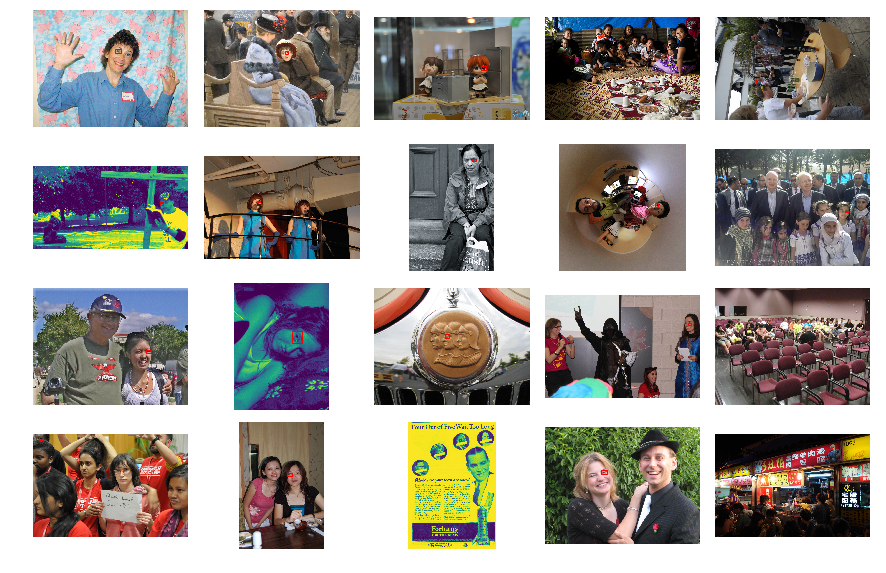

In [10]:
from funcy import first, second
import matplotlib as mpl
from random import sample as rand_subset
import imagesize

mpl.rcParams['figure.figsize'] = (15, 10)

YOLO_DIR = expanduser('~/workspaces/data/yolov3')

IMAGE_PATHS_BY_FOLDER = {k: open_images_ls(k) for k in TRAIN_DIRS}.items()

@curry
def value_includes(value, kv_pair):
    return value in second(kv_pair)

def image_path(row):
    filename = row.at['ImageID'] + '.jpg'
    
    folder = pipe(IMAGE_PATHS_BY_FOLDER,
                  filter(value_includes(filename)),
                  first, first)
    return join(DIR, folder, filename)

@curry
def bounding_box(path, row):
    w, h = imagesize.get(path)
    x1, x2 = row.at['XMin'], row.at['XMax']
    y1, y2 = row.at['YMin'], row.at['YMax']
    return x1 * w, x2 * w, y1 * h, y2 * h

def bounding_rect(row, image):
    x1, x2, y1, y2 = bounding_box(image, row)
    return mpl.patches.Rectangle(
        (x1, y1), x2 - x1, y2 - y1,
        linewidth=1,
        edgecolor='r',
        facecolor='none')

def display_box(row, axis = None):
    path = image_path(row)
    image = plt.imread(path)
    axis.imshow(image)
    axis.set_axis_off()
    axis.add_patch(bounding_rect(row, path))

IMAGE_COLS = 5
IMAGE_ROWS = 4

figure, axarr = plt.subplots(IMAGE_ROWS, IMAGE_COLS,
                             gridspec_kw = dict(wspace=0.1, hspace=0.1))

random_indices = rand_subset(range(train_ann_bbox.shape[0]), IMAGE_COLS * IMAGE_ROWS)

for idx, axis in zip(random_indices, axarr.flatten()):
    display_box(train_ann_bbox.iloc[idx], axis)

# Prepare Yolo V3 (Keras version) for Training 

https://github.com/qqwweee/keras-yolo3

In [12]:
import progressbar
from os import remove as rm

YOLO_ANCHORS_FILE = './annotations-yolo-format.txt'

rm(YOLO_ANCHORS_FILE)

def open_image_to_darknet_format(image_id, group):
    path = image_path(group.iloc[0])
    boxes = group.apply(bounding_box(path), axis=1).values.tolist()
    return path + ' ' + ' '.join([','.join(map(compose(str, round), b)) + ',0' for b in boxes])

with open(YOLO_ANCHORS_FILE, 'w') as file:
    with progressbar.ProgressBar(max_value=train_ann_bbox.ImageID.nunique()) as bar:
        i = 0
        for image_id, group in train_ann_bbox.groupby('ImageID'):
            file.write("%s\n" % open_image_to_darknet_format(image_id, group))
            i += 1
            bar.update(i)

100% (23743 of 23743) |##################| Elapsed Time: 0:04:29 Time:  0:04:29


In [13]:
# Print sample
print('Sample output:')
print('\n'.join([open_image_to_darknet_format(i, g)
                 for i, g in train_ann_bbox[0:10].groupby('ImageID')]))

Sample output:
/media/rcdilorenzo/datahouse/openimagesv4/train_08/000004f4400f6ec5.jpg 489,509,274,303,0 618,645,216,232,0 675,696,219,229,0
/media/rcdilorenzo/datahouse/openimagesv4/train_08/0000271195f2c007.jpg 424,522,429,486,0 573,650,440,494,0
/media/rcdilorenzo/datahouse/openimagesv4/train_08/000077165b72a53b.jpg 320,387,277,326,0 434,483,290,334,0
/media/rcdilorenzo/datahouse/openimagesv4/train_08/00007902a7b96e8c.jpg 429,451,246,261,0 473,483,247,263,0
/media/rcdilorenzo/datahouse/openimagesv4/train_08/0000bdfa52154160.jpg 266,314,213,236,0


In [ ]:
# WIP!!!

import train
import numpy as np
import keras.backend as K
from keras.layers import Input, Lambda
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

from yolo3.model import preprocess_true_boxes, yolo_body, tiny_yolo_body, yolo_loss
from yolo3.utils import get_random_data

MAX_LINES = 5000
YOLO_FILE = join(YOLO_DIR, 'yolov3-320.h5')
MODEL_DIR = './models/v1'
LOG_DIR = './logs/v1/'
CLASSES_FILE = './classes-yolo-format.txt'
ANCHORS_FILE = './keras-yolo3/model_data/yolo_anchors.txt'
TEMP_MODEL_FORMAT = 'ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5'
BATCH_SIZE = 32
BATCH_SIZE_FINE_TUNE = 32
TRAIN_WITH_FROZEN = True
FINE_TUNE_TRAIN = True

class_names = train.get_classes(CLASSES_FILE)
num_classes = len(class_names)
anchors = train.get_anchors(ANCHORS_FILE)

input_shape = (416, 416) # multiple of 32, hw

model = train.create_model(input_shape, anchors, num_classes, freeze_body=2, weights_path=YOLO_FILE)

logging = TensorBoard(log_dir=LOG_DIR)

checkpoint = ModelCheckpoint(
    join(MODEL_DIR, TEMP_MODEL_FORMAT),
    monitor='val_loss', save_weights_only=True, save_best_only=True, period=3)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1)

val_split = 0.1
with open(YOLO_ANCHORS_FILE) as f:
    lines = f.readlines()
        
# Shuffle
np.random.seed(10101)
np.random.shuffle(lines)
np.random.seed(None)

# Cap at maximum
lines = lines[0:MAX_LINES]

num_val = int(len(lines) * val_split)
num_train = len(lines) - num_val
train_steps = lambda size: max(1, num_train // size)
val_steps = lambda size: max(1, num_val // size)

def data_generator(subset, size):
    return train.data_generator_wrapper(subset, size, input_shape, anchors, num_classes)

# Train with frozen layers first, to get a stable loss.
# Adjust num epochs to your dataset. This step is enough to obtain a not bad model.
if TRAIN_WITH_FROZEN:
    model.compile(optimizer=Adam(lr=1e-3), loss={
        # use custom yolo_loss Lambda layer.
        'yolo_loss': lambda y_true, y_pred: y_pred})

    print('Train on {} samples, val on {} samples, with batch size {}.'.format(
        num_train, num_val, BATCH_SIZE))
    
    model.fit_generator(
        data_generator(lines[:num_train], BATCH_SIZE),
        steps_per_epoch=train_steps(BATCH_SIZE),
        validation_data=data_generator(lines[num_train:], BATCH_SIZE),
        validation_steps=val_steps(BATCH_SIZE),
        epochs=50,
        initial_epoch=0,
        callbacks=[logging, checkpoint]
    )
    
    model.save_weights(join(MODEL_DIR, 'trained_weights_base.h5'))


if FINE_TUNE_TRAIN:
    # Unfreeze
    for i in range(len(model.layers)):
        model.layers[i].trainable = True
        
    model.compile(optimizer=Adam(lr=1e-4), loss={'yolo_loss': lambda y_true, y_pred: y_pred})
    print('Unfreeze all of the layers.')

    print('Train on {} samples, val on {} samples, with batch size {}.'.format(
        num_train, num_val, BATCH_SIZE_FINE_TUNE))
    
    model.fit_generator(
        data_generator(lines[:num_train], BATCH_SIZE_FINE_TUNE),
        steps_per_epoch=train_steps(BATCH_SIZE_FINE_TUNE),
        validation_data=data_generator(lines[num_train:], BATCH_SIZE_FINE_TUNE),
        validation_steps=val_steps(BATCH_SIZE_FINE_TUNE),
        epochs=100,
        initial_epoch=50,
        callbacks=[logging, checkpoint, reduce_lr, early_stopping]
    )
    
    model.save_weights(join(MODEL_DIR, 'trained_weights_final.h5'))